In [1]:
from __future__ import print_function

import os
import sys
from os.path import join
from os.path import abspath
from os.path import split

root_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if root_dir not in sys.path:
    sys.path.append(root_dir)
root_dir = os.path.abspath(os.path.join(root_dir, 'Concepts without CEFR'))
    
import numpy as np
import pandas as pd
import pickle
import random
from tqdm import tqdm_notebook as tqdm
from pomegranate import *

import networkx as nx
import pickle
import matplotlib.pyplot as plt

import math
import scipy.stats as ss
import mplcursors
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [2]:
root_dir

'/Users/daniel/Personal/Learning/Thesis/Experiment/Concepts without CEFR'

In [3]:
def plot_normal(x_range, mu=0, sigma=1, cdf=False, **kwargs):
    '''
    Plots the normal distribution function for a given x range
    If mu and sigma are not provided, standard normal is plotted
    If cdf=True cumulative distribution is plotted
    Passes any keyword arguments to matplotlib plot function
    '''
    x = x_range
    if cdf:
        y = ss.norm.cdf(x, mu, sigma)
    else:
        y = ss.norm.pdf(x, mu, sigma)
    plt.plot(x, y, **kwargs)

def cal_structure_log_score(parent_dict, data_df):
    par_list = []
    
    for concept in concepts:
        concept_par_list = [ concepts.index(par) for par in parent_dict[concept] ]
        par_list.append(tuple(concept_par_list))
    
    par_tuple = tuple(par_list)
    print(par_tuple)
    
    network = BayesianNetwork().from_structure(X = data_df.values, structure = par_tuple, state_names = concepts)

    # calculate likelihood score
    log_score = sum(network.log_probability(X = data_df.values, n_jobs = 4))
    return log_score
    #try:
    #    network = BayesianNetwork().from_structure(X = data_df.values, structure = par_tuple, state_names = concepts)

        # calculate likelihood score
    #    log_score = sum(network.log_probability(X = data_df.values, n_jobs = 4))
    #    return log_score
    
    #except:
        # structure contains cycle
    #    return float("-inf")#'Invalid structure'  
    
def get_data(DIR):
    # get input data
    inputdata = pd.read_csv(DIR)
    
    inputdata['concept_id'] = inputdata['concept_id'].astype(str)
    concepts = sorted(inputdata['concept_id'].unique().tolist())

    data_df = inputdata.groupby([
                            'test_session', 
                            'concept_id',
                            'estimated_state'
                          ]).agg({
                            'correct': 'mean'
                          })

    data_df = data_df.reset_index()
    data_df = data_df[['test_session','concept_id','estimated_state']].set_index(['test_session','concept_id']).unstack('concept_id')

    data_df.columns = data_df.columns.map(''.join)
    data_df.columns = [col.replace('estimated_state', '') for col in data_df.columns]
    
    return data_df, concepts

In [4]:
BKT_BASED_STD_MODEL_DIR = os.path.abspath(os.path.join(root_dir, 'BKT student model'))
BKT_EVALUATE_DATA_FOLDER_DIR = os.path.abspath(os.path.join(BKT_BASED_STD_MODEL_DIR, 'State_dataset3'))

BKT_EVALUATE_DATA_DIR = os.path.abspath(os.path.join(BKT_EVALUATE_DATA_FOLDER_DIR, 'state_dataset3_bkt.csv'))

BKT_GS_MODEL_FOLDER_DIR = os.path.abspath(os.path.join(BKT_BASED_STD_MODEL_DIR, 'GS domain model'))
BKT_GS_MODEL_DIR = os.path.abspath(os.path.join(BKT_GS_MODEL_FOLDER_DIR, 'domain_model_bkt.pkl'))

BKT_GREEDY_MODEL_FOLDER_DIR = os.path.abspath(os.path.join(BKT_BASED_STD_MODEL_DIR, 'Greedy score-based domain model'))
BKT_GREEDY_MODEL_DIR = os.path.abspath(os.path.join(BKT_GREEDY_MODEL_FOLDER_DIR, 'domain_model_bkt.pkl'))

BKT_THEORY_MODEL_FOLDER_DIR = os.path.abspath(os.path.join(BKT_BASED_STD_MODEL_DIR, 'Theory-driven domain model'))
BKT_THEORY_MODEL_DIR = os.path.abspath(os.path.join(BKT_THEORY_MODEL_FOLDER_DIR, 'domain_model_bkt.pkl'))


In [55]:
THRESHOLD_BASED_STD_MODEL_DIR = os.path.abspath(os.path.join(root_dir, 'Threshold student model'))
THRESHOLD_EVALUATE_DATA_FOLDER_DIR = os.path.abspath(os.path.join(THRESHOLD_BASED_STD_MODEL_DIR, 'State_dataset3'))
# take case threshold = 60
THRESHOLD_EVALUATE_DATA_DIR = os.path.abspath(os.path.join(THRESHOLD_EVALUATE_DATA_FOLDER_DIR, 'state_dataset3_60.csv'))

THRESHOLD_GS_MODEL_FOLDER_DIR = os.path.abspath(os.path.join(THRESHOLD_BASED_STD_MODEL_DIR, 'GS domain model'))
THRESHOLD_GS_MODEL_DIR = os.path.abspath(os.path.join(THRESHOLD_GS_MODEL_FOLDER_DIR, 'domain_model_95.pkl'))

THRESHOLD_GREEDY_MODEL_FOLDER_DIR = os.path.abspath(os.path.join(THRESHOLD_BASED_STD_MODEL_DIR, 'Greedy score-based domain model'))
THRESHOLD_GREEDY_MODEL_DIR = os.path.abspath(os.path.join(THRESHOLD_GREEDY_MODEL_FOLDER_DIR, 'domain_model_95.pkl'))

THRESHOLD_THEORY_MODEL_FOLDER_DIR = os.path.abspath(os.path.join(THRESHOLD_BASED_STD_MODEL_DIR, 'Theory-driven domain model'))
THRESHOLD_THEORY_MODEL_DIR = os.path.abspath(os.path.join(THRESHOLD_THEORY_MODEL_FOLDER_DIR, 'domain_model_100.pkl'))


### Evaluate Threshold-based method

In [51]:
data, concepts = get_data(THRESHOLD_EVALUATE_DATA_DIR)

#### GS algorithm

In [52]:
model = pickle.load( open( THRESHOLD_GS_MODEL_DIR, "rb" ) )

parent_dict = {}
for concept in concepts:
    parent_dict[concept] = []
    
for edge in model.edges:
    parent_dict[edge[1]].append(edge[0])
    
threshold_based_GS_algo_score = cal_structure_log_score(parent_dict, data)
threshold_based_GS_algo_score

((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ())


-60255.49424132926

#### Greedy algorithm

In [53]:
model = pickle.load( open( THRESHOLD_GREEDY_MODEL_DIR, "rb" ) )['G']

parent_dict = {}
for concept in concepts:
    parent_dict[concept] = []
    
for edge in model.edges:
    parent_dict[edge[1]].append(edge[0])
    
threshold_based_greedy_algo_score = cal_structure_log_score(parent_dict, data)
threshold_based_greedy_algo_score

((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ())


-60255.49424132926

#### Theory algorithm

In [56]:
model = pickle.load( open( THRESHOLD_THEORY_MODEL_DIR, "rb" ) )

parent_dict = {}
for concept in concepts:
    parent_dict[concept] = []
    
print('a')
print(model.edges)
    
for edge in model.edges:
    parent_dict[edge[1]].append(edge[0])
    
threshold_based_theory_algo_score = cal_structure_log_score(parent_dict, data)
threshold_based_theory_algo_score

a
[('23', '57'), ('23', '30'), ('23', '99'), ('23', '98'), ('23', '96'), ('23', '55'), ('23', '70'), ('23', '10'), ('23', '6'), ('230', '8'), ('85', '57'), ('85', '30'), ('85', '9'), ('85', '28'), ('85', '90'), ('85', '95'), ('85', '25'), ('85', '38'), ('85', '45'), ('85', '79'), ('85', '86'), ('85', '89'), ('85', '98'), ('85', '27'), ('85', '55'), ('85', '43'), ('85', '56'), ('85', '58'), ('85', '40'), ('85', '230'), ('85', '97'), ('85', '63'), ('85', '61'), ('85', '60'), ('85', '99'), ('85', '73'), ('85', '51'), ('85', '96'), ('85', '70'), ('85', '31'), ('85', '65'), ('85', '47'), ('85', '72'), ('85', '231'), ('85', '84'), ('85', '48'), ('85', '66'), ('85', '39'), ('85', '77'), ('85', '93'), ('85', '54'), ('85', '24'), ('85', '32'), ('85', '11'), ('85', '20'), ('85', '62'), ('89', '7'), ('89', '8'), ('89', '6')]
((8,), (72,), (), (), (), (72,), (), (), (), (72,), (72,), (), (72,), (72,), (), (72,), (72,), (), (8, 72), (72,), (72,), (), (), (), (), (), (72,), (72,), (72,), (), (), (72

-53850.23389096545

### Evaluate BKT-based method

In [57]:
data, concepts = get_data(BKT_EVALUATE_DATA_DIR)

#### GS algorithm

In [59]:
model = pickle.load( open( BKT_GS_MODEL_DIR, "rb" ) )

parent_dict = {}
for concept in concepts:
    parent_dict[concept] = []
    
for edge in model.edges:
    parent_dict[edge[1]].append(edge[0])
    
bkt_based_GS_algo_score = cal_structure_log_score(parent_dict, data)
bkt_based_GS_algo_score

((), (), (), (), (), (), (), (), (), (4, 6), (9,), (3,), (8,), (), (), (), (), (), (), (4,), (), (), (), (), (), (), (), (5,), (), (), (), (), (), (), (), (7,), (), (), (), (), (), (), (), (), (), (), (1, 8), (), (), (46,), (), (), (), (), (), (), (), (1,), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (9,), (), (), (), (), (), (), (19,), (), (), ())


-52345.296057681335

#### Greedy algorithm

In [60]:
model = pickle.load( open( BKT_GREEDY_MODEL_DIR, "rb" ) )['G']

parent_dict = {}
for concept in concepts:
    parent_dict[concept] = []
    
for edge in model.edges:
    parent_dict[edge[1]].append(edge[0])
    
bkt_based_greedy_algo_score = cal_structure_log_score(parent_dict, data)
bkt_based_greedy_algo_score

((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ())


-54163.25719712484

#### Theory algorithm

In [61]:
model = pickle.load( open( BKT_THEORY_MODEL_DIR, "rb" ) )

parent_dict = {}
for concept in concepts:
    parent_dict[concept] = []
    
for edge in model.edges:
    parent_dict[edge[1]].append(edge[0])
    
bkt_based_theory_algo_score = cal_structure_log_score(parent_dict, data)
bkt_based_theory_algo_score

((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (9, 72), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (6, 37, 42, 72), (72,), ())


-53515.73642030106

## Assess BKT model

In [52]:
root_dir

'/Users/daniel/Personal/Learning/Thesis/Experiment/Concepts without CEFR'

In [58]:
BKT_MODEL_DIR = os.path.abspath(os.path.join(root_dir, 'BKT learnt models'))


concept_model = 'bkt_10.pkl'
CONCEPT_MODEL_DIR = os.path.abspath(os.path.join(BKT_MODEL_DIR, concept_model))

with open(CONCEPT_MODEL_DIR, 'rb') as f:
    bkt_A = pickle.load(f)

__________________________________________________________________

Start Prob matrix
[0.49845265 0.50154735]

Transition matrix
[[0.65942848 0.34057152]
 [0.43309395 0.56690605]]

Means and vars of each hidden state
0th hidden state
mean =  [0.25926468]
var =  [0.04755177]

1th hidden state
mean =  [0.81309949]
var =  [0.04063536]



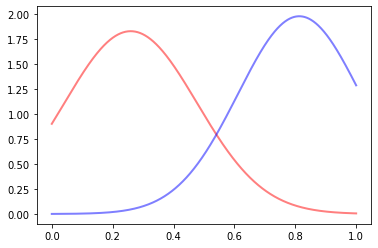

In [66]:
print("__________________________________________________________________")
print()

print("Start Prob matrix")
print(bkt_A.startprob_)
print()

print("Transition matrix")
print(bkt_A.transmat_)
print()

print("Means and vars of each hidden state")
for i in range(bkt_A.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", bkt_A.means_[i])
    print("var = ", np.diag(bkt_A.covars_[i]))
    print()

x = np.linspace(0, 1, 1000)

plot_normal(x, bkt_A.means_[0], math.sqrt(np.diag(bkt_A.covars_[0])), color='red', lw=2, ls='-', alpha=0.5)
plot_normal(x, bkt_A.means_[1], math.sqrt(np.diag(bkt_A.covars_[1])), color='blue', lw=2, ls='-', alpha=0.5)


In [82]:
P_T = []
P_F = []

learnt_mean = []
unlearnt_mean = []

learnt_var = []
unlearnt_var = []

for concept in concepts:
    concept_model = 'bkt_{}.pkl'.format(concept)
    CONCEPT_MODEL_DIR = os.path.abspath(os.path.join(BKT_MODEL_DIR, concept_model))

    with open(CONCEPT_MODEL_DIR, 'rb') as f:
        bkt_model = pickle.load(f)
        
        means = bkt_model.means_
        var_list = [ np.diag(covars) for covars in bkt_model.covars_ ]
        trans_matrix = bkt_model.transmat_
        
        if means[0] > means[1]:
            learnt_mean.append(means[0][0])
            unlearnt_mean.append(means[1][0])
            
            learnt_var.append(var_list[0][0])
            unlearnt_var.append(var_list[1][0])
            
            P_T.append(trans_matrix[1][0])
            P_F.append(trans_matrix[0][1])
            
        elif means[0] < means[1]:
            learnt_mean.append(means[1][0])
            unlearnt_mean.append(means[0][0])
            
            learnt_var.append(var_list[1][0])
            unlearnt_var.append(var_list[0][0])
            
            P_T.append(trans_matrix[0][1])
            P_F.append(trans_matrix[1][0])

d = {'Concept':concepts,'P(T)':P_T,'P(F)':P_F,'learn mean':learnt_mean,'learn var':learnt_var,'unlearn mean':unlearnt_mean,'unlearn var':unlearnt_var}
df = pd.DataFrame(d)
df = df.set_index('Concept')
df

P(T)      P(F)  learn mean  learn var  unlearn mean  unlearn var
Concept                                                                      
10       0.340572  0.433094    0.813099   0.040635      0.259265     0.047552
11       0.304195  0.460165    0.836485   0.037778      0.292587     0.049712
12       0.450351  0.446372    0.808957   0.038172      0.171486     0.036372
190      0.338334  0.551834    0.919412   0.016251      0.273132     0.059575
191      0.272408  0.499984    1.000000   0.000049      0.266376     0.062285
...           ...       ...         ...        ...           ...          ...
95       0.522521  0.377510    0.881582   0.026631      0.247018     0.053711
96       0.321332  0.324714    0.823878   0.034185      0.267825     0.053805
97       0.169998  0.228963    0.863185   0.032070      0.221685     0.044789
98       0.302814  0.369663    0.878816   0.026852      0.324413     0.060970
99       0.389656  0.440261    0.784358   0.044553      0.280332     0.053032

[88 rows x 6 columns]

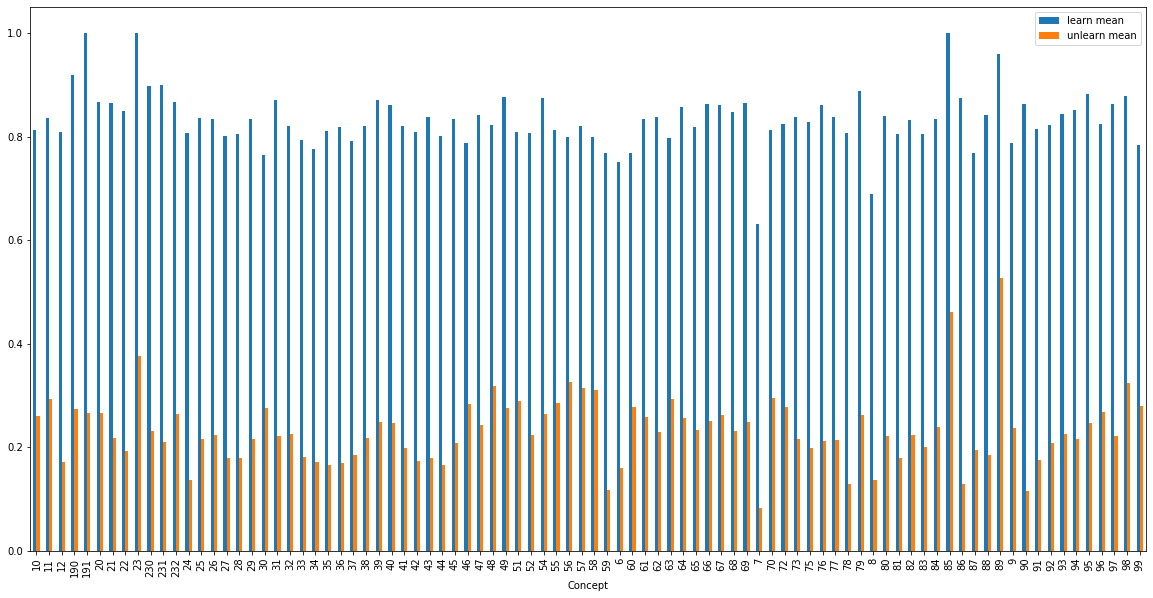

In [120]:
df[['learn mean','unlearn mean']].plot(kind='bar', figsize=(20,10))
plt.show()
#plt.savefig('Learnt_mean.png')

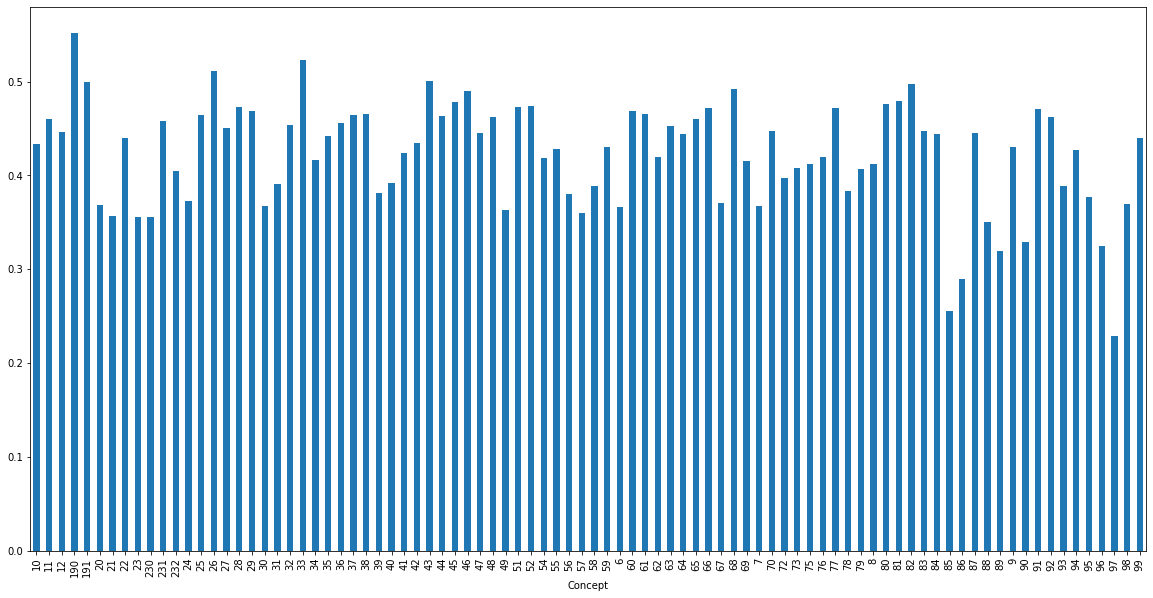

In [117]:
df['P(F)'].plot(kind='bar', figsize=(20,10))
plt.show()

In [83]:
df[df['P(T)'] == df['P(T)'].max()]

P(T)     P(F)  learn mean  learn var  unlearn mean  unlearn var
Concept                                                                    
85       0.57772  0.25585         1.0   0.000018      0.460838     0.073996

In [84]:
df['learn mean'].mean()

0.8333511459425501

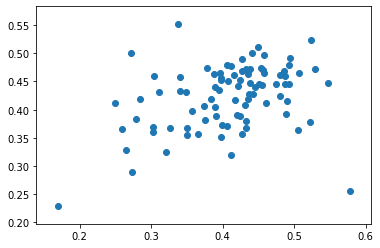

In [94]:
X = df['P(T)'].to_list()
Y = df['P(F)'].to_list()

plt.scatter(X, Y)

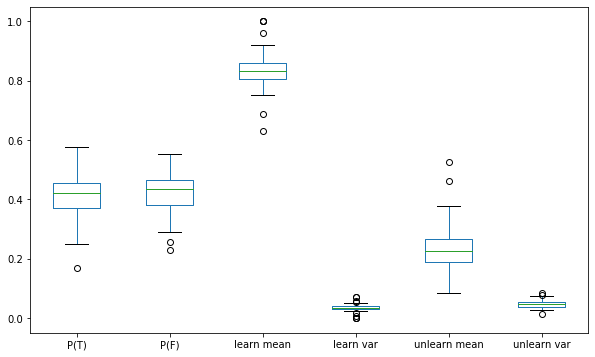

In [100]:
df.plot(kind='box', figsize=(10,6))#.plot(kind='box', subplots=True, layout=(3,2), sharex=False, sharey=False)
plt.show()

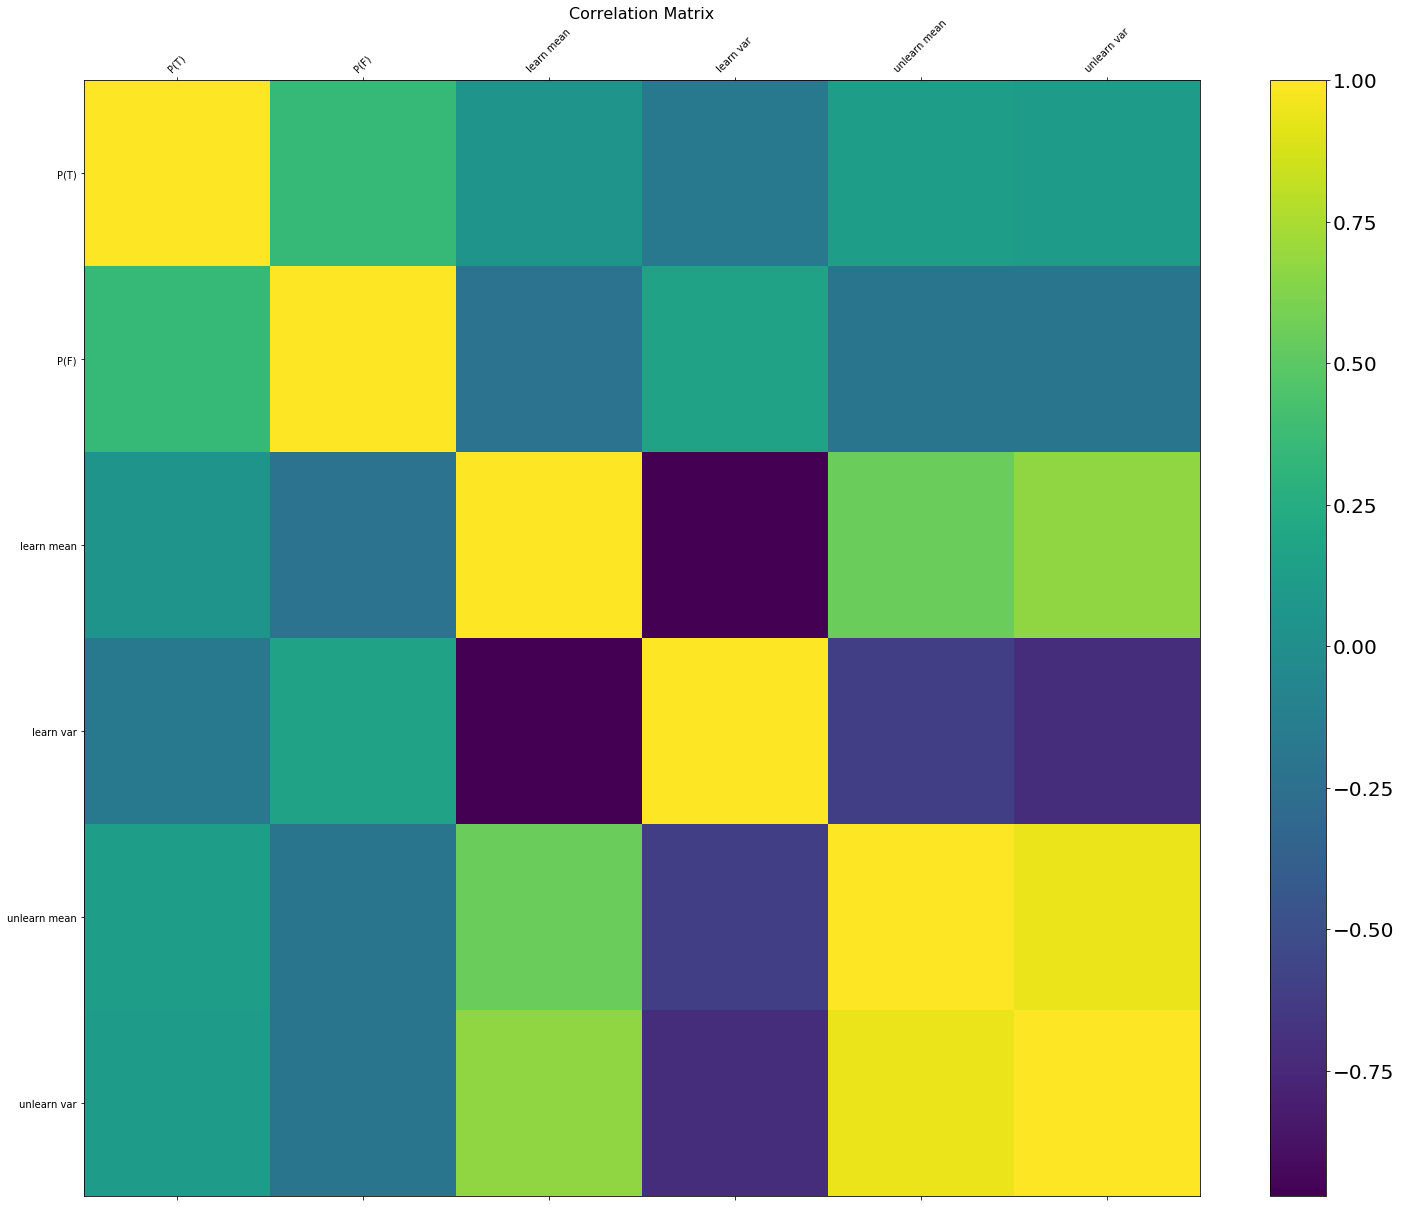

In [92]:
def plot_corr(data):
    f = plt.figure(figsize=(25, 20))
    plt.matshow(data.corr(method='pearson', min_periods=1), fignum=f.number)
    plt.xticks(range(data.shape[1]), data.columns, fontsize=10, rotation=45)
    plt.yticks(range(data.shape[1]), data.columns, fontsize=10)

    #min_corr = data.min()
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=20)
    plt.title('Correlation Matrix', fontsize=16)
    
plot_corr(df)

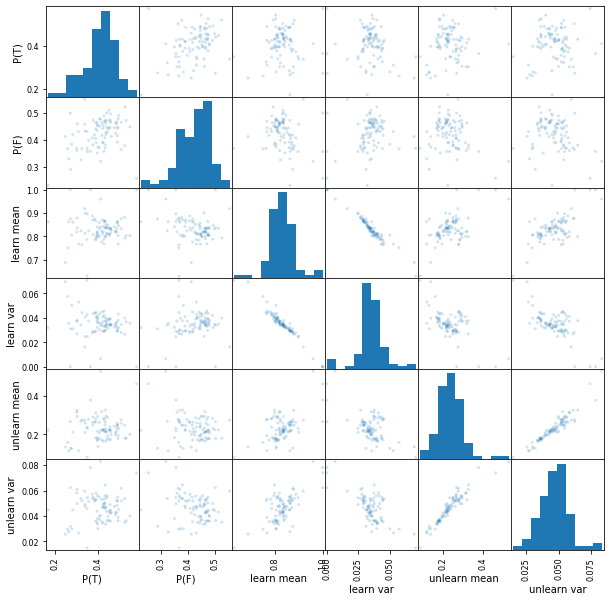

In [97]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha=0.2, figsize=(10, 10))
plt.show()

In [106]:
import scipy.stats

learn_proba = []
unlearn_proba = []

for ban in range(11):
    score = ban/10
    
    learn_proba.append(scipy.stats.norm(df['learn mean'], df['learn var']).pdf(score).mean())
    unlearn_proba.append(scipy.stats.norm(df['unlearn mean'], df['unlearn var']).pdf(score).mean())
    

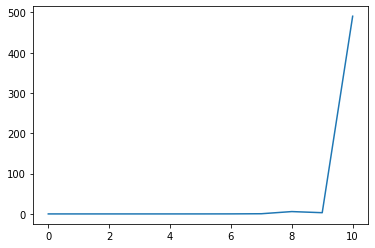

In [107]:
plt.plot(learn_proba)

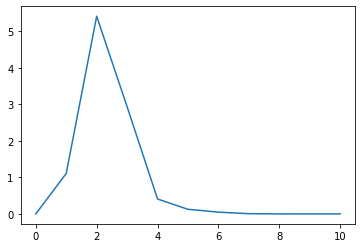

In [108]:
plt.plot(unlearn_proba)